In [1]:
!pip install git+https://github.com/VincentStimper/normalizing-flows.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-yr6ilk4y
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-yr6ilk4y
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-1wd64xvr/residual-flows_e82820ea69ec482aad0882b0f4931af2
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-1wd64xvr/residual-flows_e82820ea69ec482aad0882b0f4931af2
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=0c4785e2d3895e0e929ad29bc3b834aa68756d271187f11d2900852c8d591989
  Stored in directory: /tmp/pip-ephem-wheel-cache-t1ptl3et/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=b4a30d

In [25]:
import numpy as np
import torch
import torch.nn as nn
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.stats import multivariate_normal

# For saving and loading
import pickle
%matplotlib inline

In [3]:
K = 10
beta = 1.0
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

# NF Demo

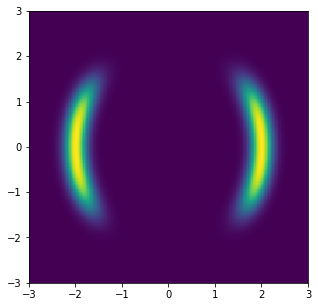

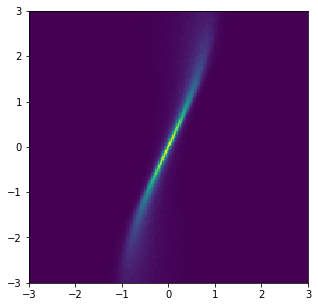

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(2), flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        z, log_q = self.q0(num_samples)
        #print(z)
        #print(log_q)
        for flow in self.flows:
            #print(flow(z))
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)


model = nfmodel(q0=nf.distributions.DiagGaussian(2), flows=flows, p=target).to(device)

 40%|███▉      | 1981/5000 [00:07<00:11, 266.66it/s]

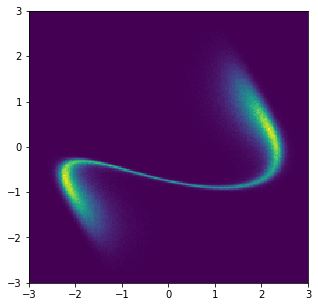

 80%|███████▉  | 3985/5000 [00:15<00:03, 260.74it/s]

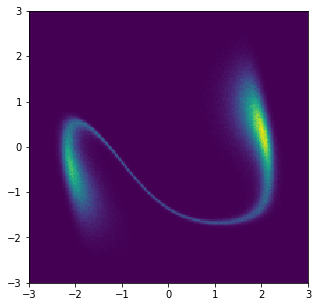

100%|██████████| 5000/5000 [00:19<00:00, 251.18it/s]


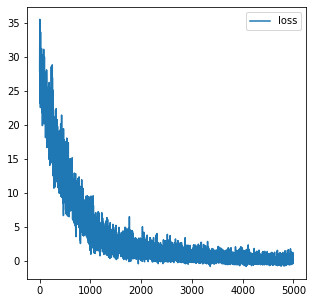

In [ ]:
# Train model
max_iter = 5000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = model.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

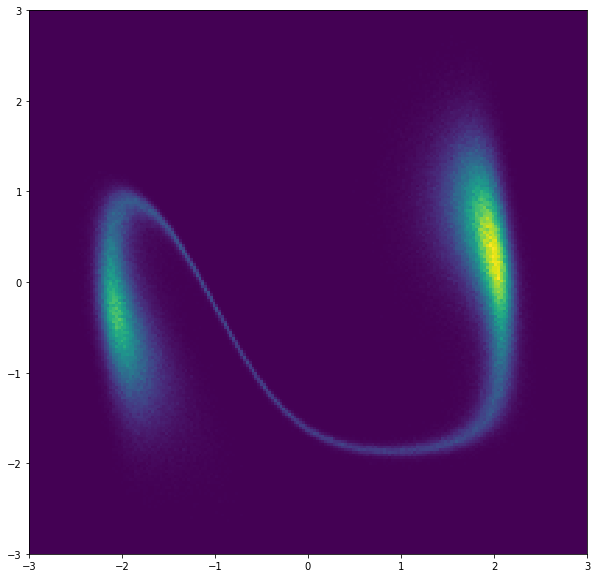

In [ ]:
# Plot learned posterior distribution
z, _ = model.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Learning water molecule distribution

In [4]:
# Install Openmm (takes approx 5 minutes to run)
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
--2022-05-27 09:40:48--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M  88.0MB/s    in 1.0s    

2022-05-27 09:40:49 (88.0 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37

In [5]:
from openmm import *
from openmm.app import *
from openmm.unit import *

# Import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [43]:
# Frequently used definitions
dtype = torch.FloatTensor
#enable_cuda = False
#device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

pdbfile = 'water.pdb' #'alanine-dipeptide.pdb'
num_atoms = 3 #22
forcefile = 'amber14/tip3pfb.xml' #'amber14-all.xml'

pklfile = 'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 64 #1024
n_cells = 25 #51
noise_var = 1
blob_var = 0.001
Q = 0.2

num_flows = 5
beta = 1.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

2.4944309407680003


In [15]:
topology = Topology()
chain = topology.addChain()
residue = topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = topology.addAtom("O", element_O, residue)
atom1 = topology.addAtom("H", element_H, residue)
atom2 = topology.addAtom("H", element_H, residue)
topology.addBond(atom0, atom1)
topology.addBond(atom0, atom2)

#pdb = PDBFile(pdbfile)
forcefield = ForceField(forcefile)
system = forcefield.createSystem(topology, nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(T*kelvin, 1/picosecond, 1*femtoseconds)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.1],
    [0.0, 0.1, 0.0],
]) * nanometers)
simulation.minimizeEnergy()
#simulation.reporters.append(PDBReporter('output.pdb', 1000))
#simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, volume=True, density=True,
#        potentialEnergy=True, temperature=True))

for i in range(1):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print("Potential energy")
    print(state0.getPotentialEnergy())

    print("Atomic positions")
    print(state0.getPositions(asNumpy=True))

    print("Volume")
    print(state0.getPeriodicBoxVolume())

    print("Forces")
    print(state0.getForces(asNumpy=True))

Potential energy
0.014260188676416874 kJ/mol
Atomic positions
[[-0.00203592  0.01448351  0.00610227]
 [-0.05764386 -0.0403806   0.07040855]
 [ 0.09576304 -0.00244567  0.02575888]] nm
Volume
8.0 nm**3
Forces
[[-27.95780563  47.57369232 -55.6378479 ]
 [ 40.33683777 -17.26897621  20.1473484 ]
 [-12.37903309 -30.3047142   35.49049759]] kJ/(nm mol)


In [ ]:
class pot_energy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        reshaped_input = input.reshape(num_atoms, 3)
        ctx.save_for_backward(reshaped_input)

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return torch.tensor(state.getPotentialEnergy()._value).to(device)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        reshaped_input, = ctx.saved_tensors

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return -grad_output * torch.tensor(state.getForces(asNumpy=True)._value).reshape(-1, num_atoms*3).to(device)

# Testing right side of pipeline

In [ ]:
flows = []
for i in range(K):
    flows += [nf.flows.Planar((num_atoms*3,))]

q0 = nf.distributions.DiagGaussian(num_atoms*3)

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(num_atoms*3), flows=flows):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        #self.p = p

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        z, log_q = self.q0(num_samples)
        #print(z[0])
        #print(log_q[0])

        for flow in self.flows:
            #print(flow(z))
            z, log_det = flow(z)
            log_q -= log_det

        log_p, translation = 0, 0
        for molecule in z:
            log_p -= pot_energy.apply(molecule.reshape(-1, num_atoms*3))
            translation += torch.mean(molecule) ** 2

        return torch.mean(log_q) - beta*log_p/(num_samples*kBxAvoxT) #+ translation/num_samples


model = nfmodel(q0=nf.distributions.DiagGaussian(num_atoms*3), flows=flows).to(device)

  0%|          | 2/5000 [00:00<05:06, 16.31it/s]

235.54364


 10%|█         | 505/5000 [00:22<03:06, 24.11it/s]

0.67045116


 20%|██        | 1002/5000 [00:43<02:56, 22.68it/s]

-7.9231033


 30%|███       | 1503/5000 [01:05<02:20, 24.89it/s]

-4.58411


 40%|████      | 2002/5000 [01:27<02:09, 23.06it/s]

-8.413696


 50%|█████     | 2506/5000 [01:49<01:44, 23.96it/s]

-9.23362


 60%|██████    | 3004/5000 [02:10<01:23, 23.93it/s]

-9.9911175


 70%|███████   | 3505/5000 [02:31<01:04, 23.30it/s]

-10.949413


 80%|████████  | 4003/5000 [02:53<00:43, 22.87it/s]

-11.380679


 90%|█████████ | 4503/5000 [03:15<00:21, 22.65it/s]

-11.306914


100%|██████████| 5000/5000 [03:36<00:00, 23.07it/s]


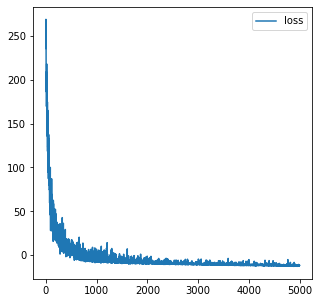

In [ ]:
# Train model
max_iter = 5000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [50]:
def torch_createblobs(coords, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=noise_var, rot_mat=torch.eye(3)):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    normals = torch.zeros_like(x, device=device)

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    new_coords = coords @ rot_mat.T

    for row in new_coords.double():
        #var = torch.distributions.multivariate_normal.MultivariateNormal(row[0:2],\
        # blob_sigma*torch.eye(2, device=device).double())
        #normals = normals + torch.exp(var.log_prob(pos))
        normals += torch.exp(-(torch.norm(pos - row[0:2], dim=2)**2)/(2*(blob_var)))/(2*torch.tensor(np.pi)*(blob_var))

    return normals/len(new_coords) + np.sqrt(noise_var)*torch.randn((n_cells, n_cells))

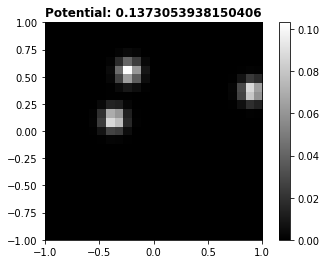

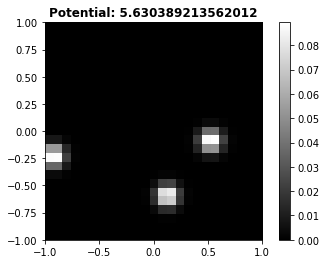

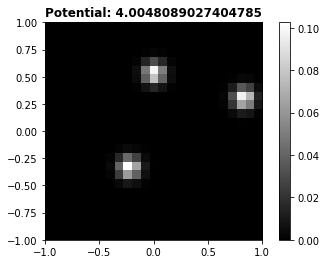

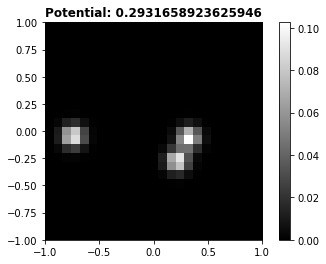

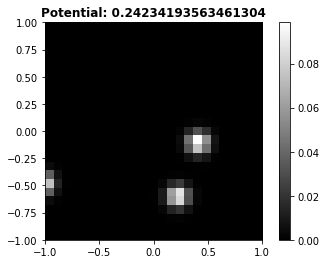

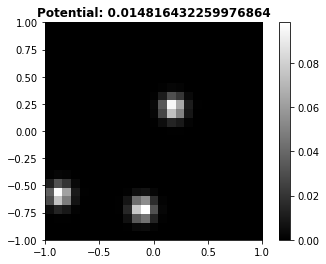

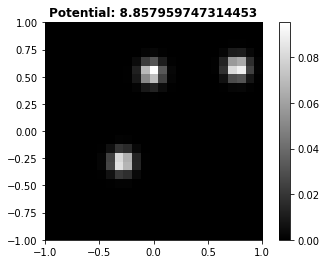

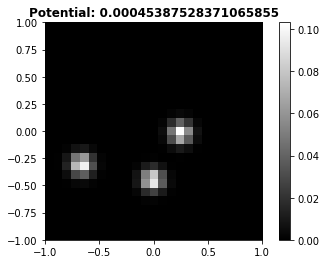

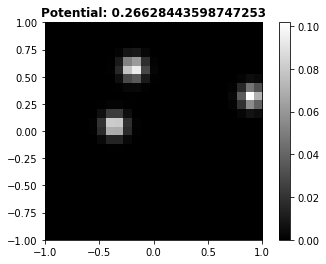

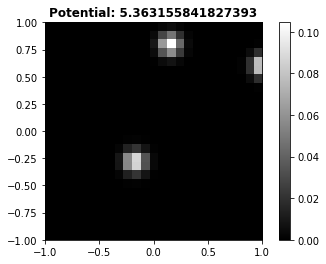

In [ ]:
molecules, _ = model.sample(num_samples=10)

for mol in molecules:
    simulation.context.setPositions(mol.reshape(3,3).data.numpy())
    state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    img = torch_createblobs(mol.reshape(3,3)).data.numpy()
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                            extent = [-1,1,-1,1], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    plt.title(f'Potential: {state.getPotentialEnergy()._value}', fontweight = "bold")
    plt.show()

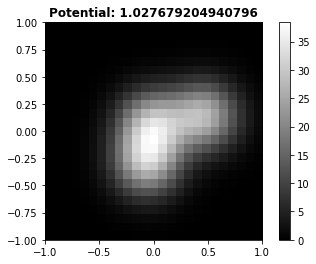

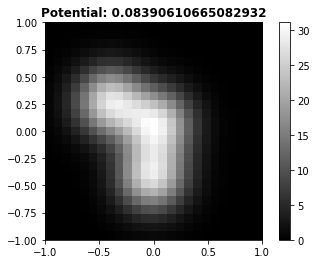

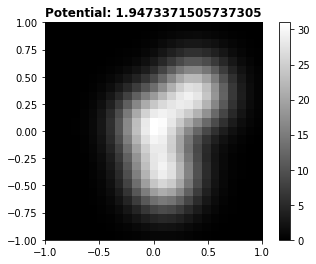

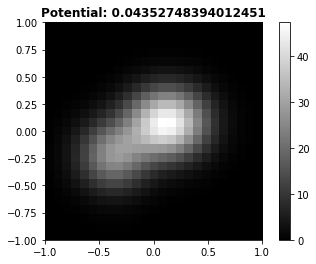

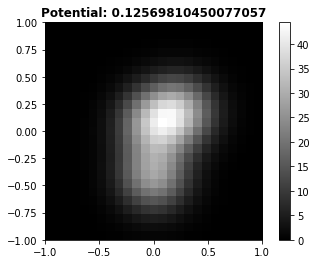

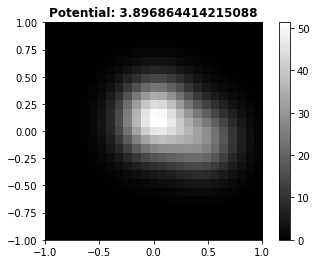

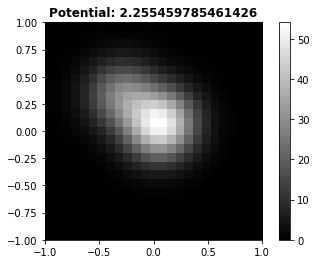

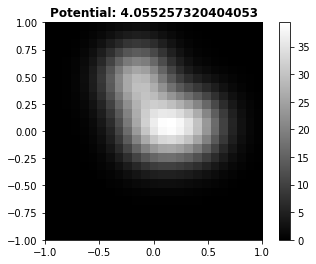

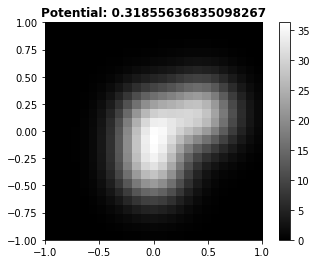

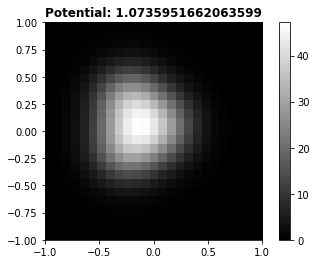

In [20]:
simulation.context.setPositions(np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.1],
    [0.0, 0.1, 0.0],
]) * nanometers)
simulation.minimizeEnergy()

for i in range(10):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
    mol = torch.from_numpy(state0.getPositions(asNumpy=True)._value).type(dtype)

    img = torch_createblobs(mol).data.numpy()
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                            extent = [-1,1,-1,1], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    plt.title(f'Potential: {state0.getPotentialEnergy()._value}', fontweight = "bold")
    plt.show()

# Create Cryo-EM torch images

In [56]:
# Generate rotation matrices
num_imgs = 1024

rot_mats = []
for n in range(num_imgs):
    r = R.from_euler('zyx', [[np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi), np.random.uniform(0, 2*np.pi)]],
                     degrees=False)
    rot_mats.append(torch.tensor(r.as_matrix()[0]).type(dtype))

In [94]:
pot_energies = []
forces_list = []
pos_list = []
img_list = []

for i in range(num_imgs):
    if i%64 == 0:
        print(f'Starting step: {i}...')
    
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
    temp_pos = state0.getPositions(asNumpy=True)
    simulation.context.setPositions(temp_pos - temp_pos.mean())

    pot_energies.append(torch.tensor(state0.getPotentialEnergy()._value).type(dtype))
    pos_list.append(torch.tensor(state0.getPositions(asNumpy=True)._value).type(dtype))
    forces_list.append(torch.tensor(state0.getForces(asNumpy=True)._value).type(dtype))
    img_list.append(torch_createblobs(pos_list[-1], Q=0.2, n_cells=25, blob_var=0.0005, noise_var=100, rot_mat=rot_mats[i]))

Starting step: 0...
Starting step: 64...
Starting step: 128...
Starting step: 192...
Starting step: 256...
Starting step: 320...
Starting step: 384...
Starting step: 448...
Starting step: 512...
Starting step: 576...
Starting step: 640...
Starting step: 704...
Starting step: 768...
Starting step: 832...
Starting step: 896...
Starting step: 960...


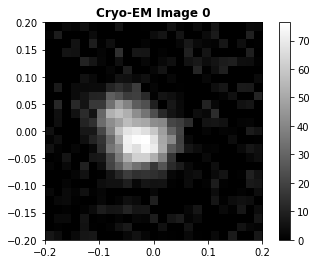

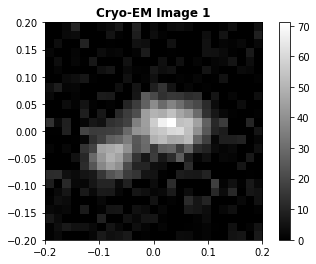

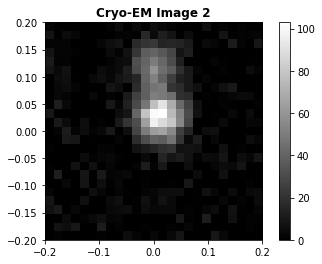

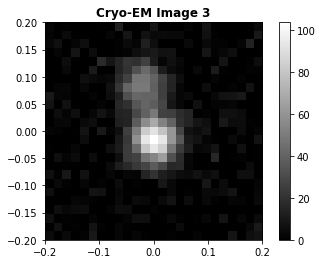

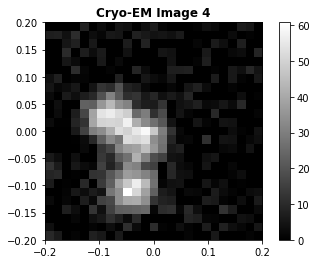

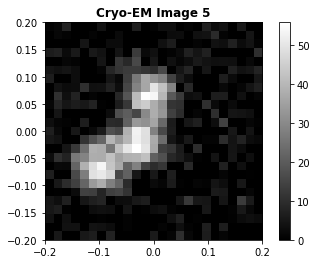

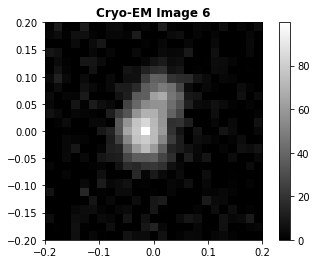

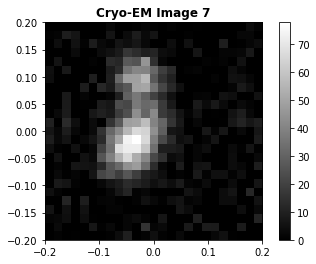

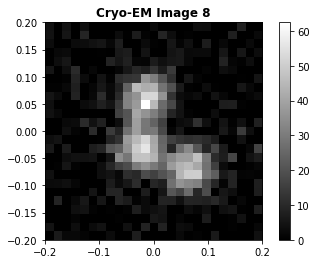

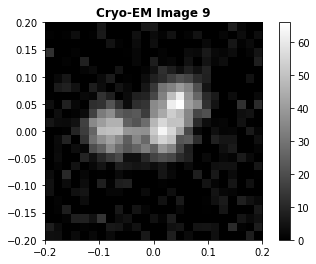

In [100]:
for idx, img in enumerate(img_list):
    if idx in [i for i in range(10)]:
        c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                          extent = [-0.2, 0.2, -0.2, 0.2], interpolation = 'nearest', origin = 'lower')
        plt.colorbar(c)
                
        plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
        plt.show()

In [96]:
with open('water_img1024_dim25_nse100_blob0.0005_q0.2.pkl', 'wb') as outp:
    pickle.dump(rot_mats, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(pot_energies, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(forces_list, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(pos_list, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(img_list, outp, pickle.HIGHEST_PROTOCOL)

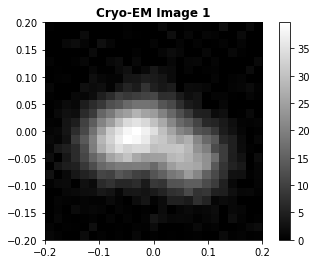

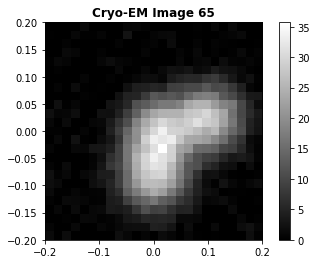

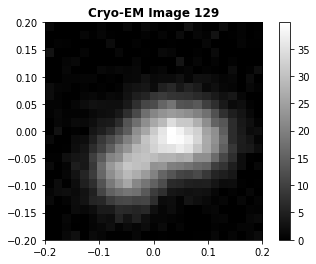

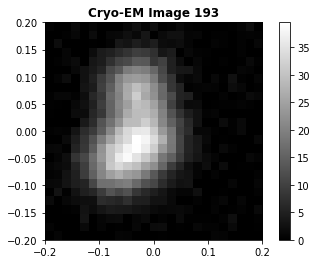

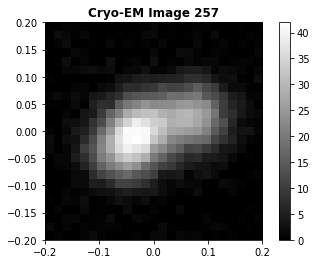

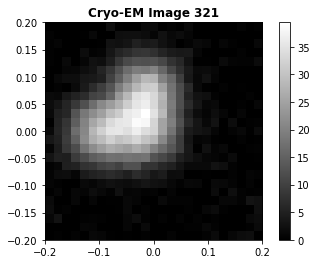

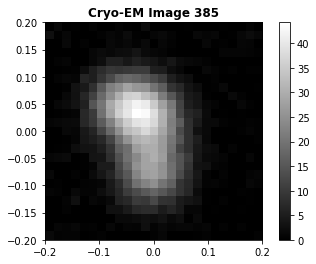

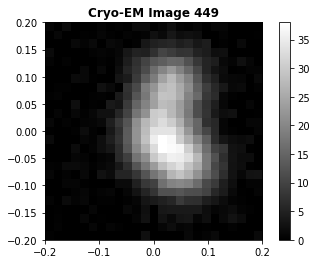

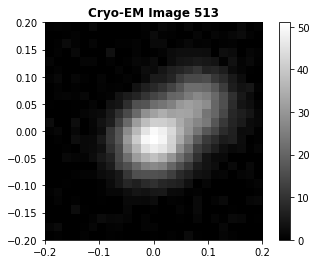

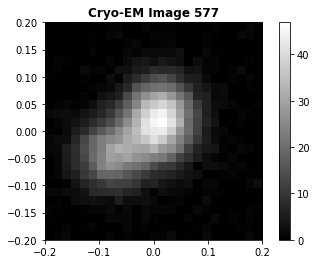

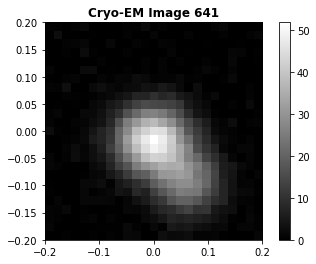

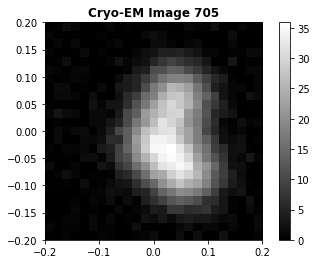

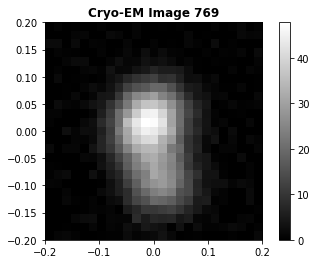

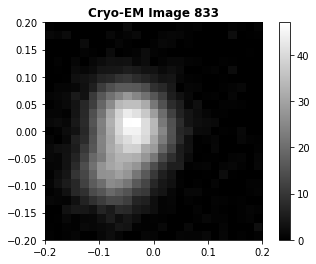

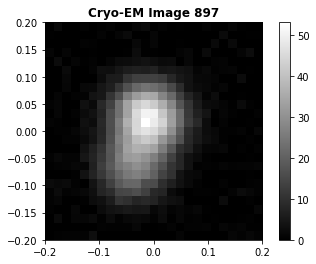

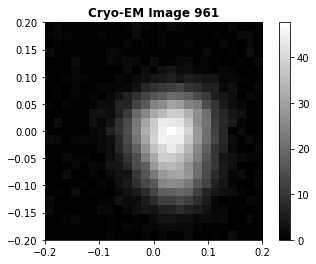

In [105]:
with open('water_img1024_dim25_nse1_blob0.002_q0.2.pkl', 'rb') as inp:
    rot_mats = pickle.load(inp)[0:num_imgs]
    pot_energies = pickle.load(inp)[0:num_imgs]
    forces_list = pickle.load(inp)[0:num_imgs]
    pos_list = pickle.load(inp)
    img_list = pickle.load(inp)[0:num_imgs]

for idx, img in enumerate(img_list):
    if idx % 64 == 0:
        c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                        extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
        plt.colorbar(c)

        plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
        plt.show()

In [64]:
print(rot_mats[8])

tensor([[-0.6901, -0.6827,  0.2403],
        [-0.2662, -0.0694, -0.9614],
        [ 0.6730, -0.7274, -0.1338]])
